# The Continuous Bag of Words (CBOW) Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).







**Steps for Training the Word Embeddings for CBOW**



1. Build the corpus vocabulary
2. Build a CBOW (context, target) generator
3. Build the CBOW model architecture
4. Train the Model
5. Get Word Embeddings



#Build Vocabulary

In [ ]:
sent1 = "He is playing in the field.".lower()
sent2 = "He is running around with his friends.".lower()
sent3 = "They are playing football.".lower()
sent4 = "It started raining while they were playing.".lower()
sent5 = "They stopped playing football and are now playing ludo.".lower()
all_text = [sent1, sent2, sent3, sent4, sent5]


In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import numpy as np

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(all_text)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in all_text]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])
print(wids)

Vocabulary Size: 24
Vocabulary Sample: [('playing', 1), ('they', 2), ('he', 3), ('is', 4), ('are', 5), ('football', 6), ('in', 7), ('the', 8), ('field', 9), ('running', 10)]
[[3, 4, 1, 7, 8, 9], [3, 4, 10, 11, 12, 13, 14], [2, 5, 1, 6], [15, 16, 17, 18, 2, 19, 1], [2, 20, 1, 6, 21, 5, 22, 1, 23]]


#Build a CBOW (context, target) generator

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['he', 'is', 'in', 'the'] -> Target (Y): playing
Context (X): ['is', 'playing', 'the', 'field'] -> Target (Y): in
Context (X): ['he', 'is', 'around', 'with'] -> Target (Y): running
Context (X): ['is', 'running', 'with', 'his'] -> Target (Y): around
Context (X): ['running', 'around', 'his', 'friends'] -> Target (Y): with
Context (X): ['it', 'started', 'while', 'they'] -> Target (Y): raining
Context (X): ['started', 'raining', 'they', 'were'] -> Target (Y): while
Context (X): ['raining', 'while', 'were', 'playing'] -> Target (Y): they
Context (X): ['they', 'stopped', 'football', 'and'] -> Target (Y): playing
Context (X): ['stopped', 'playing', 'and', 'are'] -> Target (Y): football
Context (X): ['playing', 'football', 'are', 'now'] -> Target (Y): and


# Build the CBOW model architecture


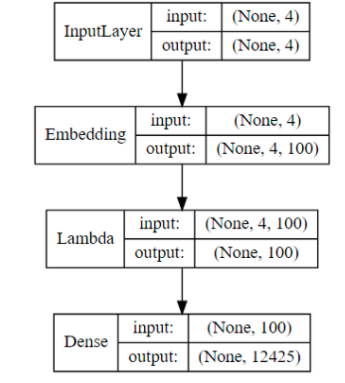

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            2400      
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
Total params: 4,824
Trainable params: 4,824
Non-trainable params: 0
_________________________________________________________________
None


We have input context words of dimensions (2 x window_size), we will pass them to an embedding layer of size (vocab_size x embed_size) which will give us dense word embeddings for each of these context words (1 x embed_size for each word). Next up we use a lambda layer to average out these embeddings and get an average dense embedding (1 x embed_size) which is sent to the dense softmax layer which outputs the most likely target word. 

We compare this with the actual target word, compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (context, target) pairs for multiple epochs

# Train the Model

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)

    print('Epoch:', epoch, '\tLoss:', loss)

Epoch: 1 	Loss: 104.72476553916931
Epoch: 2 	Loss: 103.47892761230469
Epoch: 3 	Loss: 102.42741394042969
Epoch: 4 	Loss: 101.31342434883118
Epoch: 5 	Loss: 100.11671018600464


#Get Word Embeddings

In [ ]:
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(23, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
they,0.030486,0.039976,0.030219,-0.069622,0.067078,-0.081951,-0.046559,-0.010129,-0.011008,0.024990,-0.073283,0.016297,-0.082881,0.005538,0.008447,0.042849,-0.022675,0.029915,-0.084960,-0.003863,0.015245,0.056362,-0.016824,-0.036921,0.000947,-0.064237,0.031993,-0.032348,-0.001723,-0.063993,-0.049141,-0.024952,0.008471,-0.011267,0.028992,0.046865,0.037197,0.001815,0.032506,-0.038444,...,0.051227,-0.043565,0.027827,0.002835,0.050411,-0.062797,0.042640,-0.032868,0.035046,-0.038494,0.025797,0.000153,-0.020335,0.052966,-0.065030,0.024839,-0.030880,0.084445,-0.014743,-0.042828,0.014974,0.021359,0.015587,0.023036,-0.036008,-0.061105,-0.091996,-0.037585,-0.014145,-0.074788,-0.044792,0.007249,0.018917,-0.089780,0.049966,0.010695,0.010220,0.011467,-0.016063,0.039482
he,-0.016051,0.077745,0.038809,0.027962,-0.051825,-0.004665,0.028917,-0.020883,0.074138,0.021449,0.075115,-0.035025,0.008463,0.071427,-0.097255,0.039029,-0.000817,0.079751,-0.043587,0.033737,-0.065334,0.036959,-0.011184,0.012022,-0.000810,-0.027430,0.013446,-0.028950,-0.018066,-0.021472,-0.041716,-0.008583,0.011834,0.022133,-0.006892,0.028505,0.055893,0.032171,-0.031692,-0.049802,...,0.011682,0.000490,-0.012096,0.005009,0.080468,0.065325,0.047101,0.005679,-0.021609,0.000357,0.004157,-0.047062,0.053456,0.003499,0.067414,-0.030469,0.056962,-0.036084,0.086260,0.050993,0.085062,0.096418,0.038571,-0.040489,-0.038898,0.013246,0.034319,0.022611,-0.036105,-0.029715,-0.014141,0.016834,-0.048904,0.012732,-0.035297,-0.050300,0.009863,0.091211,0.034385,0.021238
is,0.045331,-0.026839,0.037894,0.001329,0.019708,0.014840,0.043717,-0.044056,0.008051,0.062939,0.057500,0.001807,0.026604,-0.063558,-0.018007,-0.046542,-0.045039,0.032985,-0.003637,-0.012883,-0.041869,0.005923,-0.035126,0.053741,-0.031699,0.042902,-0.072568,-0.000156,0.016963,-0.005922,-0.020250,0.013562,-0.051780,-0.008512,0.018147,0.075330,-0.013817,0.037239,-0.077463,0.044440,...,0.066567,0.030118,0.002930,-0.075753,-0.030968,-0.007321,-0.043586,0.061684,-0.001192,-0.007296,0.080052,0.014588,0.082191,0.009916,-0.004976,-0.044975,0.083995,-0.066332,0.029396,-0.002528,-0.034782,0.007545,0.047776,-0.024492,0.035008,-0.091160,-0.032903,0.036268,-0.026411,-0.052537,0.032105,0.039537,-0.024156,-0.042531,0.010131,-0.070350,-0.072665,-0.038063,0.037442,0.040594
are,0.012919,0.035459,0.027777,0.043561,0.094345,0.018323,0.029916,0.028899,0.003916,-0.058095,-0.045317,0.006066,0.032160,-0.000763,-0.011489,-0.031697,0.023832,-0.047862,-0.029199,0.076078,-0.075265,-0.005286,-0.041172,0.026996,0.000426,0.048214,-0.059612,-0.065134,-0.010983,0.045681,-0.062823,0.015573,0.016459,-0.073480,-0.053235,0.002654,-0.009743,-0.006856,0.016068,-0.057740,...,-0.054202,0.026832,0.044731,0.039049,0.039006,-0.045706,-0.040751,-0.014460,0.030755,0.023849,0.045426,0.003227,-0.053048,0.046921,0.011683,-0.028609,0.021474,0.003784,-0.037055,0.027784,-0.030631,-0.065221,-0.023969,-0.049653,0.009929,0.014884,-0.032981,-0.012083,0.003387,0.010993,0.048969,-0.033256,-0.026179,0.012712,-0.028767,-0.085320,-0.065821,0.078879,-0.037403,-0.006246
football,0.039883,0.026581,0.096000,0.013017,0.025004,-0.093070,0.029644,-0.042395,0.041601,0.024951,-0.030658,-0.019309,0.008769,0.021780,0.002601,-0.059748,-0.027155,0.071731,-0.010916,0.025809,0.055036,-0.067887,-0.077651,-0.003096,0.003765,0.024025,0.017992,-0.024819,-0.056419,-0.013791,0.019309,-0.014417,0.054780,-0.044247,-0.070628,-0.006662,0.095363,0.048586,-0.006650,-0.043932,...,0.022446,0.036428,0.046270,0.021618,-0.053825,0.042643,-0.043936,0.034320,-0.065541,-0.034753,-0.030163,0.010315,0.010988,0.102139,-0.036634,0.089812,-0.009327,0.006196,0.030776,-0.002068,0.048374,0.049822,0.021830,-0.066258,0.009639,-0.069064,-0.078378,0.013185,0.018457,0.050066,-0.032855,-0.037267,0.001807,0.